Классификация: превышает ли значение IC50 медианное значение выборки

Сразу установим все, что нужно

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier,
                             GradientBoostingClassifier,
                             HistGradientBoostingClassifier,
                             AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score,
                           f1_score, precision_score,
                           recall_score, confusion_matrix)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_excel("Данные_для_курсовои_Классическое_МО 4.xlsx")
cols_to_drop= ['CC50, mM', 'SI', 'Unnamed: 0']
df = df.drop(cols_to_drop, axis=1)
display(df.head())

,"IC50, mM",MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,...,0,0,0,0,0,0,0,0,3,0
3,1.705624,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,...,0,0,0,0,0,0,0,0,0,0


Топ-10 наиболее важных дескрипторов для IC50:
VSA_EState4         0.062637<br>
Chi1n               0.041884<br>
FpDensityMorgan3    0.040449<br>
Chi4v               0.039201<br>
Chi2v               0.038437<br>
BCUT2D_MRLOW        0.035050<br>
Chi2n               0.024153<br>
SlogP_VSA5          0.020892<br>
Chi3n               0.020464<br>
EState_VSA4         0.020019<br>

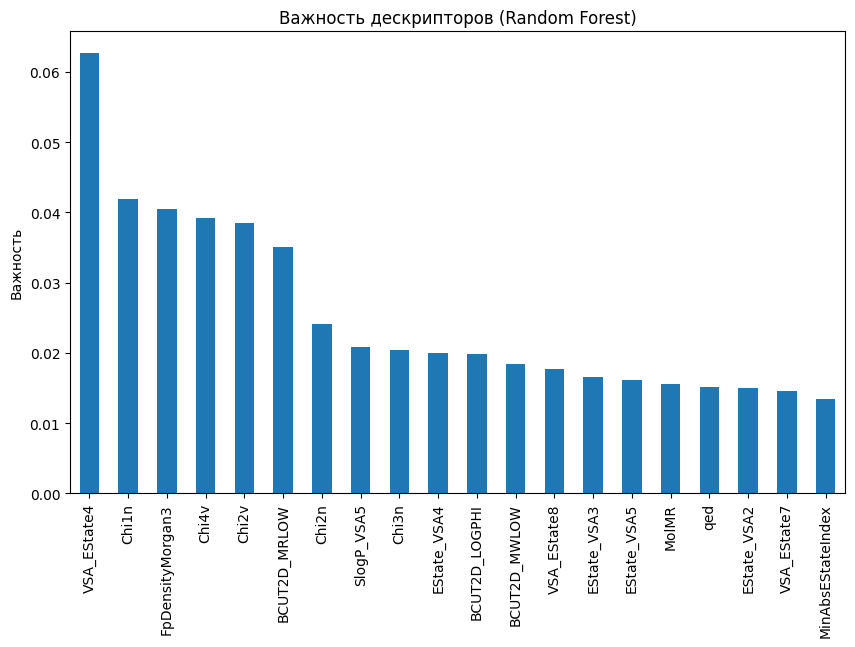

Сперва настроим стиль для дальнейшей визуализации

In [22]:
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('ggplot')

sns.set_theme(style="whitegrid")
sns.set_palette("husl")


## Подготовка данных и обработка выбросов
Уберем выбросы по IC50, рассчитаем среднее и создадим новый признак, который станет у нас целевой пременной

In [23]:
original_count = len(df)
print(f"Исходное количество записей: {original_count}")

mean_cc50 = df['IC50, mM'].mean()
std_cc50 = df['IC50, mM'].std()
lower_bound = mean_cc50 - 2 * std_cc50
upper_bound = mean_cc50 + 2 * std_cc50

df = df[(df['IC50, mM'] >= lower_bound) & (df['IC50, mM'] <= upper_bound)].copy()
filtered_count = len(df)
print(f"Количество записей после удаления выбросов: {filtered_count}")
print(f"Удалено записей: {original_count - filtered_count}")

# Создание целевой переменной
df['IC50_Above_Median'] = (df['IC50, mM'] > df['IC50, mM'].median()).astype(int)
target = 'IC50_Above_Median'

Исходное количество записей: 1001
Количество записей после удаления выбросов: 945
Удалено записей: 56


Инжиниринг признаков

In [24]:
cols_to_exclude = ['IC50, mM', 'CC50, mM', 'SI', target]
X = df.drop(columns=[col for col in cols_to_exclude if col in df.columns], errors='ignore')
y = df[target]

df_engineered = X.copy()

if 'MolLogP' in df_engineered.columns and 'MolWt' in df_engineered.columns:
    df_engineered['MolLogP_x_MolWt'] = df_engineered['MolLogP'] * df_engineered['MolWt']

polynomial_features_cols = ['MolLogP', 'MolWt']
existing_poly_cols = [col for col in polynomial_features_cols if col in df_engineered.columns]

if existing_poly_cols:
    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(df_engineered[existing_poly_cols])
    poly_feature_names = poly.get_feature_names_out(existing_poly_cols)

    new_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_engineered.index)
    for col in new_poly_df.columns:
        if col not in df_engineered.columns:
            df_engineered[col] = new_poly_df[col]

if 'MolLogP' in df_engineered.columns:
    df_engineered['MolLogP_gt_3'] = (df_engineered['MolLogP'] > 3).astype(int)

if df_engineered.isnull().values.any():
    imputer = SimpleImputer(strategy='median')
    df_engineered = pd.DataFrame(imputer.fit_transform(df_engineered),
                               columns=df_engineered.columns)

Определение моделей и функции оценки

In [25]:
# Модели для классификации
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'Stacking': StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(random_state=42)),
            ('xgb', XGBClassifier(random_state=42)),
            ('gb', GradientBoostingClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression()
    )
}

def evaluate_classifier(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                       random_state=42, stratify=y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    metrics = {
        'Model': model.__class__.__name__,
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
        'F1': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    }

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model.__class__.__name__} Confusion Matrix')
    plt.show()

    return metrics

Обучение и оценка моделей

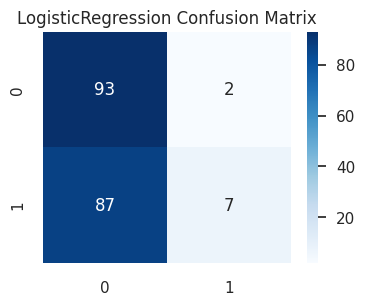

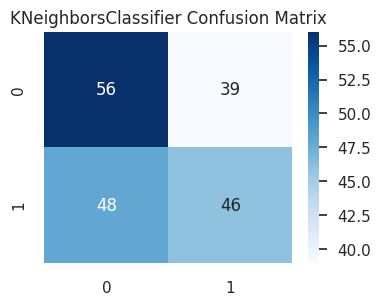

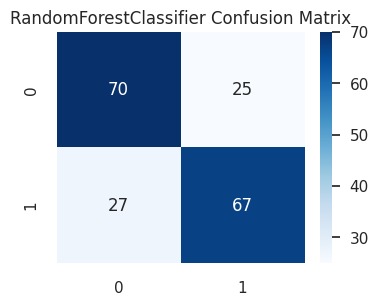

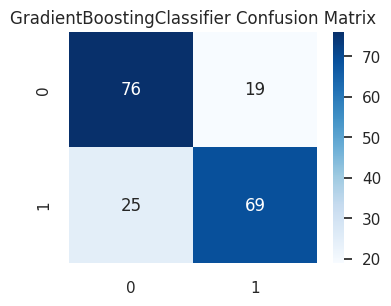

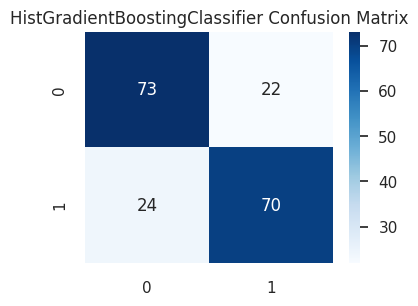

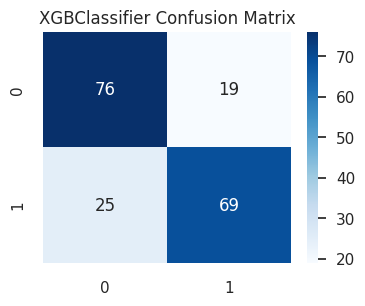

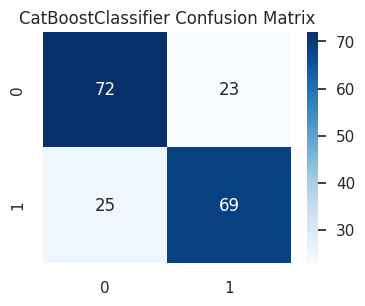

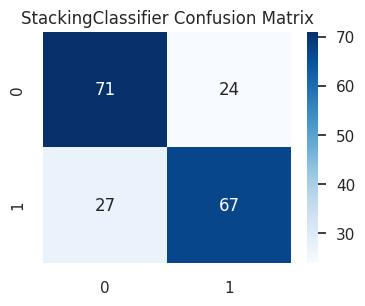

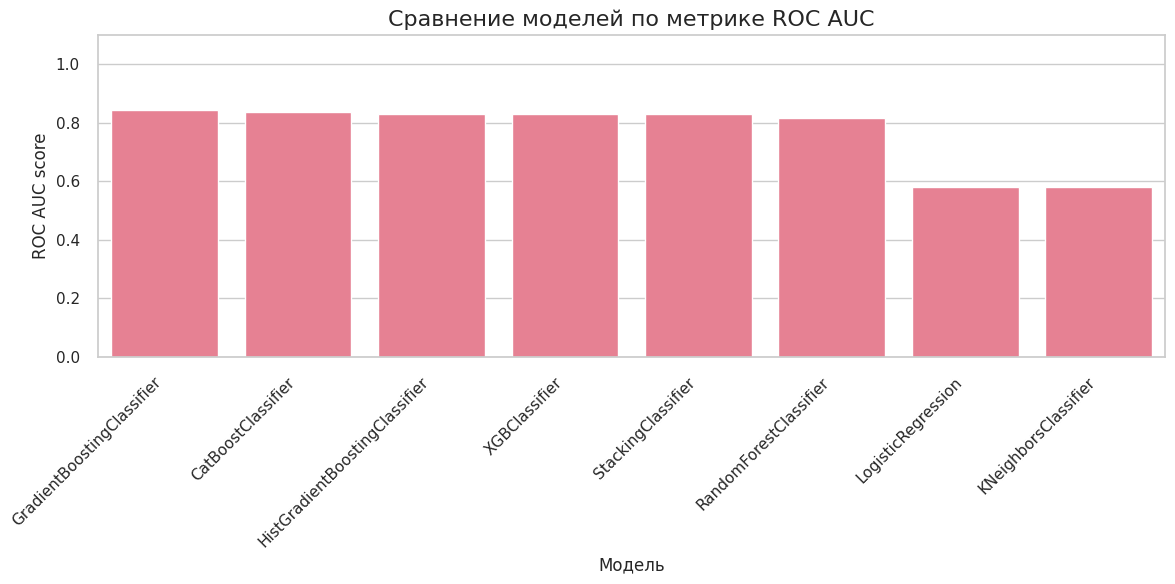


Результаты классификации:


,Model,Accuracy,ROC AUC,F1,Precision,Recall
3,GradientBoostingClassifier,0.767,0.844,0.758,0.784,0.734
6,CatBoostClassifier,0.746,0.838,0.742,0.750,0.734
4,HistGradientBoostingClassifier,0.757,0.830,0.753,0.761,0.745
5,XGBClassifier,0.767,0.828,0.758,0.784,0.734
7,StackingClassifier,0.730,0.828,0.724,0.736,0.713
2,RandomForestClassifier,0.725,0.816,0.720,0.728,0.713
0,LogisticRegression,0.529,0.581,0.136,0.778,0.074
1,KNeighborsClassifier,0.540,0.580,0.514,0.541,0.489


In [26]:
results = []
best_model = None
best_roc_auc = -np.inf

for name, model in classification_models.items():
    try:
        metrics = evaluate_classifier(model, df_engineered, y)
        results.append(metrics)

        if metrics['ROC AUC'] > best_roc_auc:
            best_roc_auc = metrics['ROC AUC']
            best_model = model

    except Exception as e:
        print(f"Ошибка при обучении {name}: {str(e)}")

results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False).round(3)

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='ROC AUC', data=results_df.sort_values('ROC AUC', ascending=False))
plt.title('Сравнение моделей по метрике ROC AUC', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.ylabel('ROC AUC score')
plt.xlabel('Модель')
plt.tight_layout()
plt.show()

def display_beautiful_table(df):
    styles = [
        {'selector': 'th', 'props': [('background-color', '#40466e'),
                                    ('color', 'white'),
                                    ('font-weight', 'bold'),
                                    ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f5f5f5')]},
        {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', 'white')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]}
    ]
    return (df.style
              .set_table_styles(styles)
              .format({'Accuracy': '{:,.3f}',
                      'ROC AUC': '{:,.3f}',
                      'F1': '{:,.3f}',
                      'Precision': '{:,.3f}',
                      'Recall': '{:,.3f}'})
              .highlight_max(subset=['ROC AUC'], color='#90EE90')
              .highlight_min(subset=['ROC AUC'], color='#FFCCCB'))

print("\nРезультаты классификации:")
display(display_beautiful_table(results_df))

Создадим красивую таблицу для отображения результатов

In [27]:
# Сохранение лучшей модели
if best_model is not None:
    best_model_name = results_df.iloc[0]['Model']
    filename = f'best_model_for_CC_50_{best_model_name}.pkl'
    joblib.dump(best_model, filename)
    print(f"\nЛучшая модель '{best_model_name}' сохранена в файл: {filename}")


Лучшая модель 'GradientBoostingClassifier' сохранена в файл: best_model_for_CC_50_GradientBoostingClassifier.pkl


Лучшие модели
GradientBoostingClassifier показал наивысшую эффективность:
Accuracy = 76.7% (лучший результат)<br>
ROC AUC = 0.844 (максимальный показатель среди всех моделей)<br>
F1 = 0.758 (хороший баланс между точностью и полнотой)<br>
Precision = 0.784 (высокая доля верных предсказаний положительного класса)<br>

CatBoostClassifier и HistGradientBoostingClassifier также продемонстрировали высокое качество:
ROC AUC ≈ 0.83–0.84 (близко к лидеру)<br>
F1 ≈ 0.74–0.75 (стабильные результаты)
<br><br>
XGBoost и StackingClassifier показали сопоставимые результаты:<br>
Accuracy ≈ 73–76.7%<br>
ROC AUC ≈ 0.828–0.830<br>
F1 ≈ 0.72–0.76<br>

RandomForest оказался чуть хуже (ROC AUC = 0.816), но сохранил приемлемое качество.
<br><br>
Наименее эффективные модели
LogisticRegression и KNN показали низкую эффективность:<br>
ROC AUC ≈ 0.58 (близко к случайному угадыванию)<br>
F1 = 0.136 (LogisticRegression) и 0.514 (KNN) – плохой баланс Precision/Recall<br>